In [1]:
import os
import json
import wandb
import subprocess
import random
from tqdm import tqdm
from PIL import Image
import torch
import numpy as np
import io
from openai import OpenAI
import base64
from pydantic import BaseModel

# %%
import torch
from sd_pipeline import StableDiffusion3Pipeline
from diffusers import StableDiffusion3Pipeline as StableDiffusion3PipelineVanilla

from sd_processor import JointAttnProcessor2_0
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")
for block in pipe.transformer.transformer_blocks:
    block.attn.processor = JointAttnProcessor2_0()

/home/wg25r/miniconda/envs/mochi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 9/9 [00:02<00:00,  3.10it/s]


In [2]:
# use different model for positive and negative detection? CLIP for positive and detection for negative

Using seed: 1748213348


100%|██████████| 16/16 [00:05<00:00,  3.07it/s]


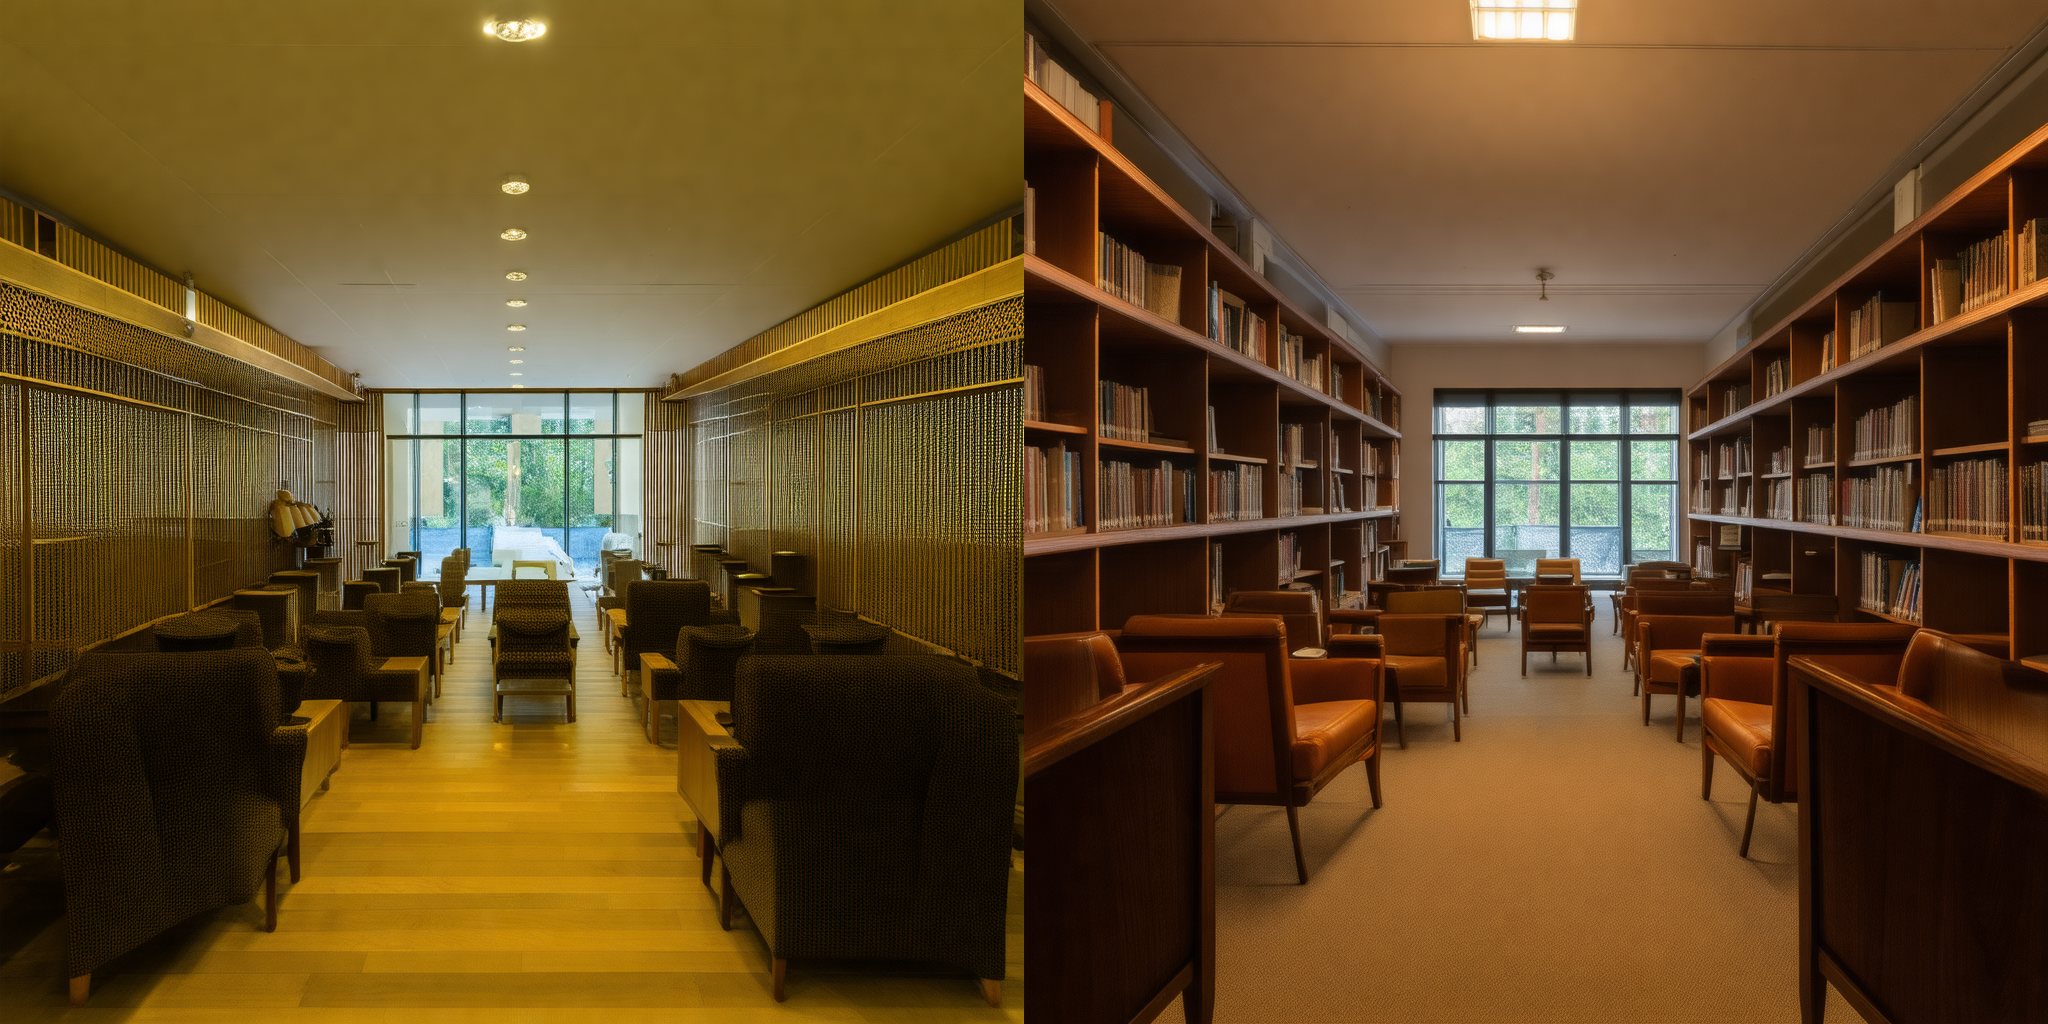

In [3]:
# positive_prompt = "A bustling Italian pizzeria with diners gathered around tables topped with plates of various food, glasses, and cutlery. The wood-fired oven glows in the background as people share meals and conversation in a warmly lit, authentic atmosphere, checkered tablecloths and rustic decor throughout."
# negative_prompt = "pizza"
positive_prompt = "A quiet reading room with rows of wooden shelves, cozy armchairs and large windows letting in soft daylight, evoking a tranquil and studious atmosphere for visitors."
negative_prompt = "book"
import time
seed = int(time.time())
print(f"Using seed: {seed}")    

for block in pipe.transformer.transformer_blocks:
    block.attn.processor.neg_prompt_len=max([
        len(pipe.tokenizer.tokenize(negative_prompt)), 
        len(pipe.tokenizer_2.tokenize(negative_prompt)),
        len(pipe.tokenizer_3.tokenize(negative_prompt))
    ]) + 1 


image_ours = pipe(
    positive_prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    avoidance_factor=10, 
    guidance_scale=7, 
    negative_offset=-8.2, #-8
    clamp_value=20, 
    generator=torch.manual_seed(seed),  
).images

negative_guidance_scales = pipe.negative_guidance_scales
weight_maps = pipe.weight_maps
image_vanilla = pipe(
    positive_prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    guidance_scale=7, 
    vanilla=True,
    generator=torch.manual_seed(seed),
).images

Image.fromarray(
            np.concatenate(
                [np.array(image_ours[-1]), np.array(image_vanilla[-1])], axis=1
            ) 
 ) 

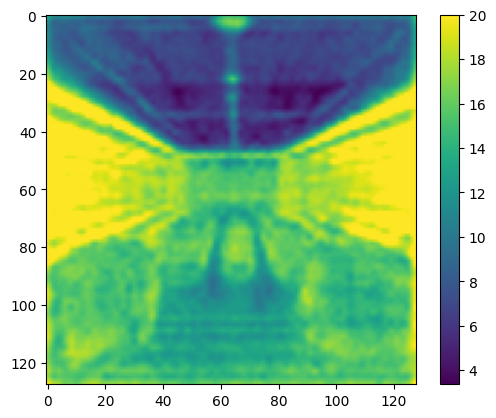

In [4]:
import pylab
pylab.imshow(weight_maps[5].mean(0).mean(0).cpu().float().numpy())
pylab.colorbar()

In [5]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForImageTextRetrieval

processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-large-coco")
model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-large-coco").to("cuda")

raw_image = image_ours[-1]

question = "there are " + negative_prompt + " visible in the image"
# question = positive_prompt
inputs = processor(raw_image, question, return_tensors="pt").to("cuda")


with torch.no_grad():
    itm_scores = torch.nn.functional.softmax(model(**inputs)[0], dim=-1)
    cosine_score = model(**inputs, use_itm_head=False)[0]
itm_scores, cosine_score


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


(tensor([[0.8757, 0.1243]], device='cuda:0'),
 tensor([[0.2153]], device='cuda:0'))

In [6]:
import requests
from PIL import Image
import torch
from PIL import ImageDraw

from transformers import Owlv2Processor, Owlv2ForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

In [7]:
text_labels = [[negative_prompt]]
raw_image = image_ours[-1].copy()
inputs = processor(text=text_labels, images=raw_image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.tensor([(raw_image.height, raw_image.width)])
# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_grounded_object_detection(
    outputs=outputs, target_sizes=target_sizes, threshold=0.13, text_labels=text_labels
)

# Retrieve predictions for the first image for the corresponding text queries
result = results[0]
boxes, scores, text_labels = result["boxes"], result["scores"], result["text_labels"]
for box, score, text_label in zip(boxes, scores, text_labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text_label} with confidence {round(score.item(), 3)} at location {box}")

# draw boxes 
draw = ImageDraw.Draw(raw_image)
for box, score, text_label in zip(boxes, scores, text_labels):
    box = [round(i, 2) for i in box.tolist()]
    draw.rectangle(box, outline="red", width=3)
    draw.text((box[0], box[1]), f"{text_label} {round(score.item(), 3)}", fill="red")
print(scores.max())
raw_image

RuntimeError: max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.